# Spatial upscaling of failure probability of flood defence

In this example, we will demonstrate how to apply the concept of spatial upscaling to the failure probabilities of flood defenses. The random variables are subject to spatial correlation, which affects the failure probability of a flood defense. The upscaling involves translating the failure probability per cross-section (length = 0 meters) to the failure probability per section (length > 0 meters).

Spatial upscaling is influenced by a concept known as the length effect. The length effect refers to the increase in failure probability when moving from a cross-section to a longitudinal segment, and from a single segment to an entire flood defense system. In other words, it captures how an increase in length affects the probability of failure.

The spatial upscaling technique is applied over homogeneous reaches of the flood defense, where "homogeneous" means the statistical characteristics remain constant.

First, let's import the necessary package:

In [1]:
from probabilistic_library import ReliabilityProject, DistributionType, ReliabilityMethod, LengthEffectProject
import numpy as np
import matplotlib.pyplot as plt
from utils.printing import print_results

Next, we define a simple limit state function. In this example, we assume that this limit state function descrives the failure of a flood defence.

$Z = 1.9 - (a+b)$

This is a linear model involving two variables, $a$ and $b$.

In [2]:
from utils.models import linear_a_b

To perform a reliability analysis, we create a `ReliabilityProject()` and specify the limit state function (model). In this example, we assume that the variables `a` and `b` are normally distributed. We use the `form` calculation technique to derive the failure probability $P(Z<0)$, which corresponds to the failure probability for a cross-section.

In [3]:
project = ReliabilityProject()
project.model = linear_a_b

project.variables["a"].distribution = DistributionType.normal
project.variables["a"].mean = 0.0
project.variables["a"].deviation = 1.0
project.variables["b"].distribution = DistributionType.normal
project.variables["b"].mean = -1.0
project.variables["b"].deviation = 1.0

project.settings.reliability_method = ReliabilityMethod.form
project.settings.relaxation_factor = 0.75
project.settings.maximum_iterations = 50
project.settings.variation_coefficient = 0.02

project.run()
dp_cross_section = project.design_point
pf_cross_section = dp_cross_section.probability_failure

print("Reliability results for a cross-section:")
project.design_point.print()

Reliability results for a cross-section:
Reliability (FORM)
 Reliability index = 2.0506096654409878
 Probability of failure = 0.020152487181270412
 Convergence = 0.0080101940056288 (converged)
 Model runs = 15
Alpha values:
 a: alpha = -0.7071067811865476, x = 1.45
 b: alpha = -0.7071067811865476, x = 0.44999999999999996



In the probabilistic library, the spatial correlation of a random variable is described by the following autocorrelation function:

$\rho_x + (1-\rho_x)\cdot\exp(-x^2/d_x^2)$

where: <br>
$x$ - distance from the cross-section (m) <br>
$d_x$ - spatial correlation length (m) <br>
$\rho_x$ - minimum correlation of the variable between two locations of the same (homogeneous) segment (-) <br>

The parameter $d_x$ determines how quickly the correlation of the variable decreases over distance. Both parameters, $d_x$ and $\rho_x$, need to be determined for each variable based on a combination of measurements and expert judgment.

In [4]:
def autocorrelation(x, d_x, rho_x):
    return rho_x + (1-rho_x)*np.exp(-x**2/d_x**2)

Let's assume that $d_x$ is $100$ and $200$ meters, respectively, for `a` and `b`, while $\rho_x$ is $0.45$ and $0.55$, respectively. Then the corresponding autocorrelation functions are as follows:

Text(0.5, 0, 'distance from the cross-section [m]')

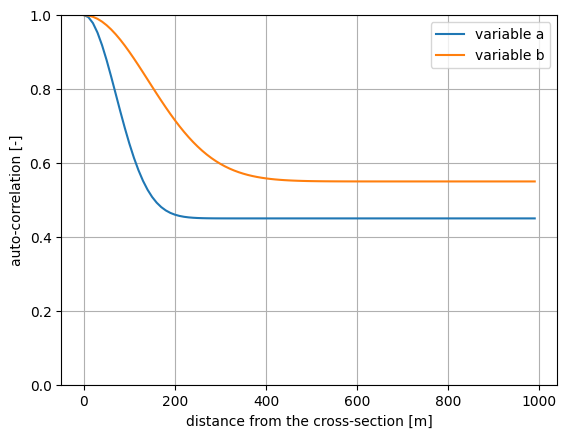

In [5]:
d_x = [100.0, 200.0]
rho_x = [0.45, 0.55]
x = np.arange(0.0, 1000.0, 10.0)

autocorr_a = [autocorrelation(val, d_x[0], rho_x[0]) for val in x]
autocorr_b = [autocorrelation(val, d_x[1], rho_x[1]) for val in x]

plt.plot(x, autocorr_a, label='variable a')
plt.plot(x, autocorr_b, label='variable b')
plt.ylim([0, 1])
plt.grid()
plt.legend()
plt.ylabel('auto-correlation [-]')
plt.xlabel('distance from the cross-section [m]')

The goal is to derive the failure probability for a section with a length greater than $0$ meters using the above autocorrelation functions for the variables `a` and `b`. To account for the spatial correlation, we define a `LengthEffectProject()`. We specify the cross-sectional results and the spatial correlation parameters $d_x$ and $\rho_x$.

In [6]:
length_effect = LengthEffectProject()

length_effect.design_point_cross_section = dp_cross_section
length_effect.correlation_lengths = d_x
length_effect.correlation_matrix["a"] = rho_x[0]
length_effect.correlation_matrix["b"] = rho_x[1]

We run the reliability calculations for different section lengths using `length_effect.run()`. The results are stored in `length_effect.design_point`.

Text(0.5, 0, 'section length [m]')

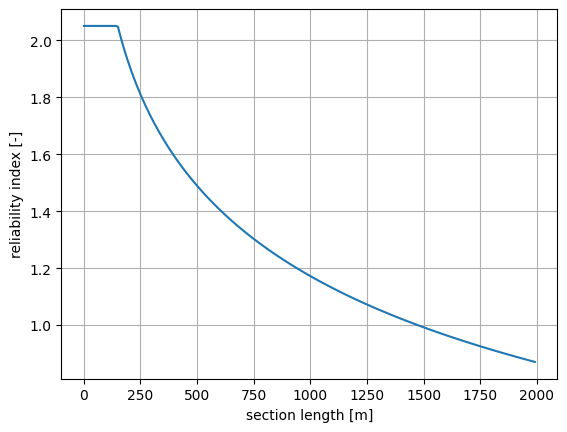

In [7]:
section_length = np.arange(1.0, 2000.0, 10.0)
beta_section = []
pf_section = []

for val in section_length:

    length_effect.length = val
    length_effect.run()
    dp_section = length_effect.design_point
    beta_section.append(dp_section.reliability_index)
    pf_section.append(dp_section.probability_failure)

plt.plot(section_length, beta_section)
plt.grid()
plt.ylabel('reliability index [-]')
plt.xlabel('section length [m]')

The length effect is defined as the ratio of the failure probability of a section to the failure probability of a cross-section.

Text(0.5, 0, 'section length [m]')

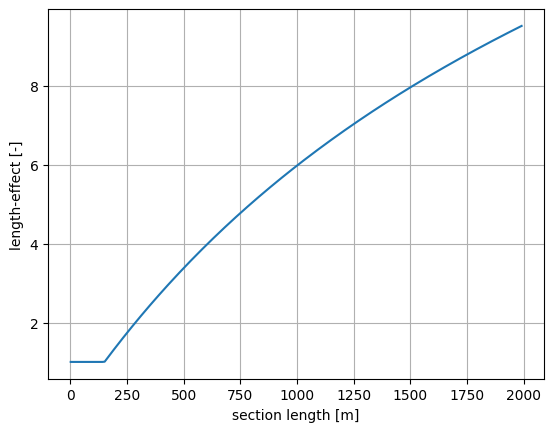

In [8]:
length_effect = [val/pf_cross_section for val in pf_section]

plt.plot(section_length, length_effect)
plt.grid()
plt.ylabel('length-effect [-]')
plt.xlabel('section length [m]')

It is also possible to gain insight into the intermediate results of the length-effect calculations. These include:
* $\Delta L$ - length of equal components in the considered section (m)
* $\rho_Z$ - residual correlation length of the limit state function (-)
* $d_Z$ - correlation length of the limit state function (m)

These intermediate results are stored in the `messages` attribute of a `design_point`.

In [9]:
if (len(dp_section.messages)> 0):
    print(dp_section.messages[0].text)

Intermediate results: Delta L = 150.180655; rhoZ = 0.500000; dZ = 122.859023
